In [1]:
from getpass import getpass
import os
from dotenv import load_dotenv

# 載入環境變數
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
# 假如沒有找到環境變數就手動輸入
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

In [2]:
import os
# 禁用 tokenizers 的並行處理，詳最後面的說明
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
from datasets import load_dataset
from haystack import Document

# 加載數據集
dataset = load_dataset(
    "bilgeyucel/seven-wonders", split="train"
)
docs = [
    Document(content=doc["content"],
    meta=doc["meta"]) for doc in dataset
]

In [4]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

# 初始化內存文件儲存
document_store = InMemoryDocumentStore()

In [5]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

# 初始化 `文件嵌入器`
# 將整個文件嵌入到一個向量表示中，以捕捉文件整體的語義信息
doc_embedder = SentenceTransformersDocumentEmbedder(
    model="sentence-transformers/all-MiniLM-L6-v2"
)
# 加載嵌入器，這是一種優化手段，用於預先加載和初始化資源密集型組件
# 可確保系統在運行時能迅速響應並保持高效的運行狀態
# 可有效避免首次運行的延遲問題，提升整體系統的性能和穩定性
doc_embedder.warm_up()

/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/sentence_transformers/SentenceTransformer.py:174: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v3 of SentenceTransformers.
  warnings.warn(
/Users/samhsiao/Documents/PythonVenv/envHaystack/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# 將文件轉換成嵌入
docs_with_embeddings = doc_embedder.run(docs)
# 將嵌入寫到 document_store 中
document_store.write_documents(
    docs_with_embeddings["documents"]
)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

151

In [7]:
from haystack.components.embedders import SentenceTransformersTextEmbedder

# 建立 `文本` 嵌入器
text_embedder = SentenceTransformersTextEmbedder(
    model="sentence-transformers/all-MiniLM-L6-v2"
)

In [8]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

# 建立 `內存嵌入檢索器`
retriever = InMemoryEmbeddingRetriever(document_store)

In [9]:
from haystack.components.generators import OpenAIGenerator

# 初始化 OpenAI 生成器
generator = OpenAIGenerator(model="gpt-4-turbo")

In [10]:
from haystack.components.builders import PromptBuilder

# 定義模板提示
template = """
根據以下信息，回答問題。

上下文:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

問題: {{question}}
答案:
"""

In [11]:
# 初始化提示生成器
prompt_builder = PromptBuilder(template=template)

In [12]:
from haystack import Pipeline

# 初始化管道
basic_rag_pipeline = Pipeline()

In [13]:
# 添加組件到管道
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

In [14]:
# 連接組件
# 將 `text_embedder` 的 `embedding` 輸出連接到 `retriever` 的 `query_embedding` 輸入
basic_rag_pipeline.connect(
    "text_embedder.embedding",
    "retriever.query_embedding"
)
# 因為 `prompt_builder` 有兩個輸入 `documents` 和 `question`
# 而這裡顯式連接了 `retriever` 到 `prompt_builder` 的 `documents`
basic_rag_pipeline.connect(
    "retriever",
    "prompt_builder.documents"
)
# 將 `prompt_builder` 連接到 `llm`
basic_rag_pipeline.connect(
    "prompt_builder",
    "llm"
)

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

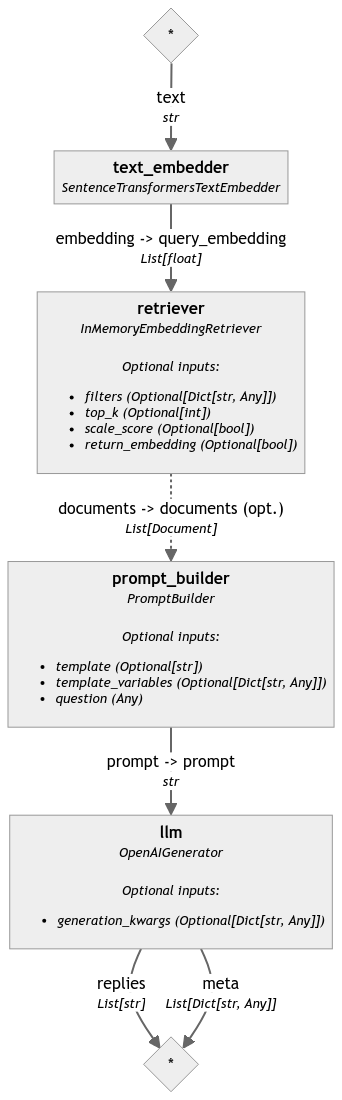

In [15]:
from utils.draw_pipeline import draw_and_display

draw_and_display(basic_rag_pipeline, "ex03_1_pipe.png")

In [16]:
# 這僅僅是提問的範例供作參考
'''
Rhodes 雕像是什麼樣子的？
巴比倫花園在哪裡？
人們為什麼要建造吉薩大金字塔？
人們為什麼參觀阿耳忒彌斯神殿？
羅德島巨像的重要性是什麼？
摩索拉斯墓發生了什麼事？
羅德島巨像是怎麼崩潰的？
'''
# 提問
question = "人們為什麼參觀阿耳忒彌斯神殿？"

In [17]:
response = basic_rag_pipeline.run({
    "text_embedder": {"text": question},
    "prompt_builder": {"question": question}
})

# 輸出答案
print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

人們參觀阿耳忒彌斯神殿因為它是一個重要的宗教和文化景點，吸引了商人、國王以及觀光者。許多人前來向阿耳忒彌斯致敬，通過獻上珠寶和各種商品。此外，阿耳忒彌斯神殿也提供避難所給那些逃避迫害或懲罰的人，這種傳統與神話中的亞馬遜人有關，他們曾兩度逃到這裡尋求女神的保護，分別是逃避狄俄尼索斯和赫拉克勒斯的懲罰。
